In [7]:
!curl http://images.cocodataset.org/annotations/annotations_trainval2017.zip --output data/annotations.zip
!tar -xf data/annotations.zip -C data/

In [9]:
!curl http://images.cocodataset.org/zips/train2017.zip --output data/train_images.zip
!tar -xf data/train_images.zip -C data/

In [ ]:
!curl http://images.cocodataset.org/zips/val2017.zip --output data/val_images.zip 
!tar -xf data/val_images.zip -C data/

In [ ]:
%pip install matplotlib
%pip install pycocotools

In [2]:
from modules.coco import COCO
from modules.coco_labels_paper import labels as coco_labels
import cv2
import os
import time
import random
from itertools import cycle


In [3]:
TRAIN_ANNOTATIONS = 'data/annotations/instances_train2017.json'
TRAIN_IMAGES = 'data/train2017'
TRAIN_OUTPUT_DIR = 'data/train'
VAL_ANNOTATIONS = 'data/annotations/instances_val2017.json'
VAL_IMAGES = 'data/val2017'
VAL_OUTPUT_DIR = 'data/validation'

TRANSFER_IMAGES = 'data/transfer'
TRANSFER_TRAIN_OUT = 'data/transfer_train'
TRANSFER_VAL_OUT = 'data/transfer_val'

In [27]:
def rescale(cvimg):
    newimg = cv2.resize(cvimg, (224, 224))
    return newimg


def crop(cvimg, ann):
    bbox = ann['bbox']
    left = int(bbox[0])
    right = int(bbox[0]+bbox[2])
    top = int(bbox[1])
    bottom = int(bbox[1]+bbox[3])
    newimg = cvimg[top:bottom, left:right]
    return newimg


def augment(cvimg):
    newimg = cvimg
    (r, g, b) = cv2.split(newimg)
    r = r*random.uniform(0.8, 1.2)
    g = g*random.uniform(0.8, 1.2)
    b = b*random.uniform(0.8, 1.2)
    newimg = cv2.merge([r,g,b])
    return newimg


def ts():
    return str(int(round(time.time() * 1000)))


def generate_dataset(anns_path: str, imgs_path: str, output_dir: str, augment: bool) -> None:
    c = COCO(anns_path)
    print(c)

    amounts = [len(c.getAnnIds(catIds=[i+1])) for i in range(len(coco_labels))]
    print(amounts)


    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

        for cn in coco_labels:
            os.mkdir(f"{output_dir}/{cn}")

        for i, val in enumerate(c.anns):
            ann = c.anns[val]
            print(f'{i} : {len(c.anns)}')

            class_name = coco_labels[ann['category_id']-1].strip()
            img = c.loadImgs(ann['image_id'])
            file_name = img[0]['file_name']

            cvimg = cv2.imread(os.path.join(imgs_path, file_name))
            cvimg = crop(cvimg, ann)

            if cvimg.shape[0] <= 1 or cvimg.shape[1] <= 1:
                continue

            cv2.imwrite("{3}/{0}/{2}{1}".format(class_name, file_name,
                                                ts(), output_dir), cvimg)

    if not augment:
        return

    max_amount = max(len(os.listdir("{1}/{0}".format(c, output_dir))) for c in os.listdir(output_dir))
    print(max_amount)

    for folder in os.listdir(output_dir):
        print(folder)
        class_amount = len(os.listdir(f'{output_dir}/{folder}'))

        if class_amount == 0:
            continue

        diff = abs(max_amount - class_amount)

        generated = 0
        gen_cycle = cycle(os.listdir(f'{output_dir}/{folder}'))

        while True:
            f = next(gen_cycle)
            cvimg = cv2.imread(f'{output_dir}/{folder}/{f}')
            cvimg = augment(cvimg)
            cv2.imwrite(f'{output_dir}/{folder}/{ts()}{f}', cvimg)
            generated += 1
            print(f'Generated {generated} for class {folder}')
            if generated >= diff:
                break

In [ ]:
generate_dataset(TRAIN_ANNOTATIONS, TRAIN_IMAGES, TRAIN_OUTPUT_DIR, False)
generate_dataset(VAL_ANNOTATIONS, VAL_IMAGES, VAL_OUTPUT_DIR, False)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90],
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'apple'),
  Text(2, 0, 'backpack'),
  Text(3, 0, 'banana'),
  Text(4, 0, 'baseball bat'),
  Text(5, 0, 'baseball glove'),
  Text(6, 0, 'bear'),
  Text(7, 0, 'bed'),
  Text(8, 0, 'bench'),
  Text(9, 0, 'bicycle'),
  Text(10, 0, 'bird'),
  Text(11, 0, 'blender'),
  Text(12, 0, 'boat'),
  Text(13, 0, 'book'),
  Text(14, 0, 'bottle'),
  Text(15, 0, 'bowl'),
  Text(16, 0, 'broccoli'),
  Text(17, 0, 'bus'),
  Text(18, 0, 'cake

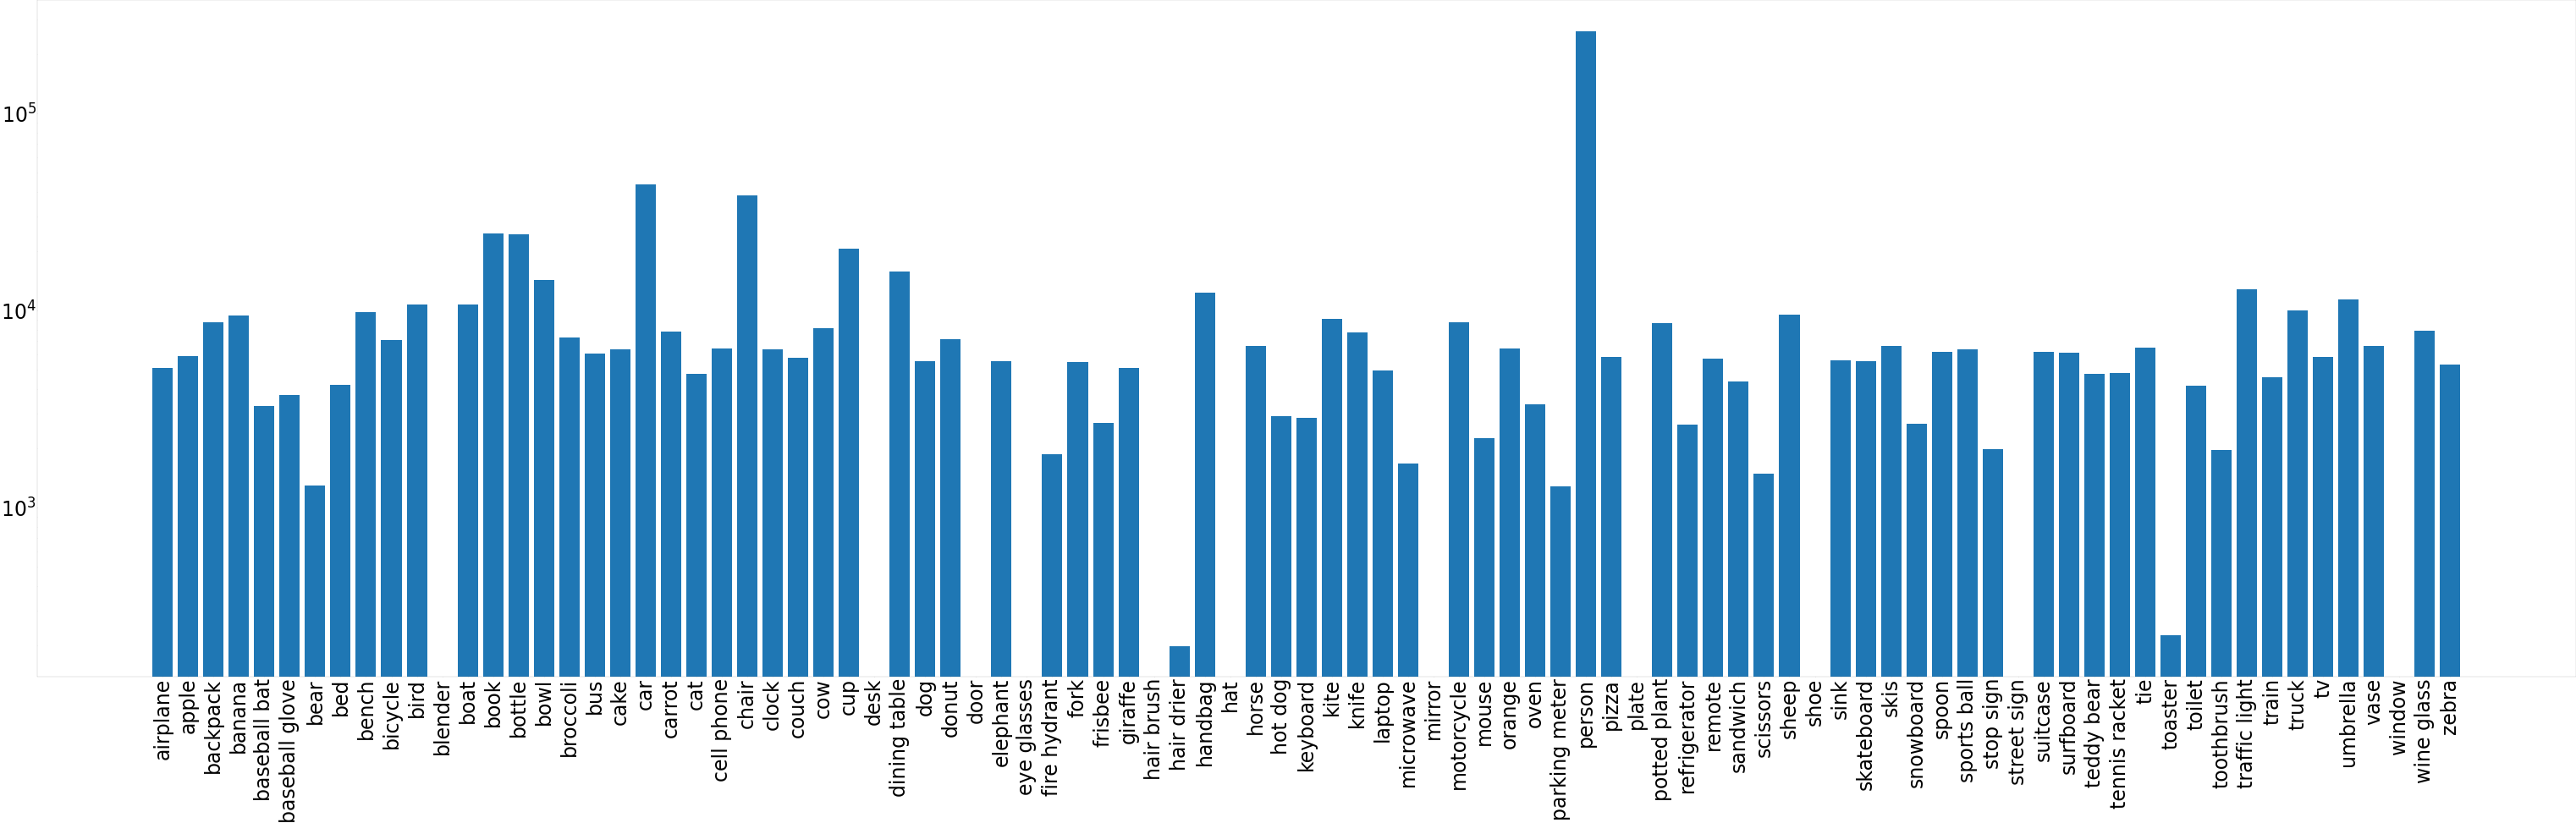

In [29]:
import matplotlib as plt
import numpy as np

amounts = []
for c in os.listdir("data/train"):
    amounts.append((c, len(os.listdir("data/train/{0}".format(c)))))

amounts = np.array(amounts)
plt.rcParams.update({'font.size': 170})
fig = plt.pyplot.figure(figsize=(300,80), dpi=10)
ax = fig.add_axes([0,0,1,1])
ax.bar(amounts[:,0], np.asarray(amounts[:,1],dtype=int))

plt.pyplot.yscale("log")
plt.pyplot.xticks(rotation=90)

In [34]:
removecount = 0

for c in os.listdir("data/train"):
    for file in os.listdir(f"data/train/{c}"):
        filepath = f"data/train/{c}/{file}"
        cvimg = cv2.imread(filepath)
        
        if cvimg.shape[0] < 80 or cvimg.shape[1] < 80:
            os.remove(filepath)
            removecount += 1

print(f"filtered: {removecount} images")

filtered: 593867 images


In [ ]:
removecount = 0

for c in os.listdir("data/validation"):
    for file in os.listdir(f"data/validation/{c}"):
        filepath = f"data/validation/{c}/{file}"
        cvimg = cv2.imread(filepath)
        
        if cvimg.shape[0] < 80 or cvimg.shape[1] < 80:
            os.remove(filepath)
            removecount += 1

print(f"filtered: {removecount} images")

91


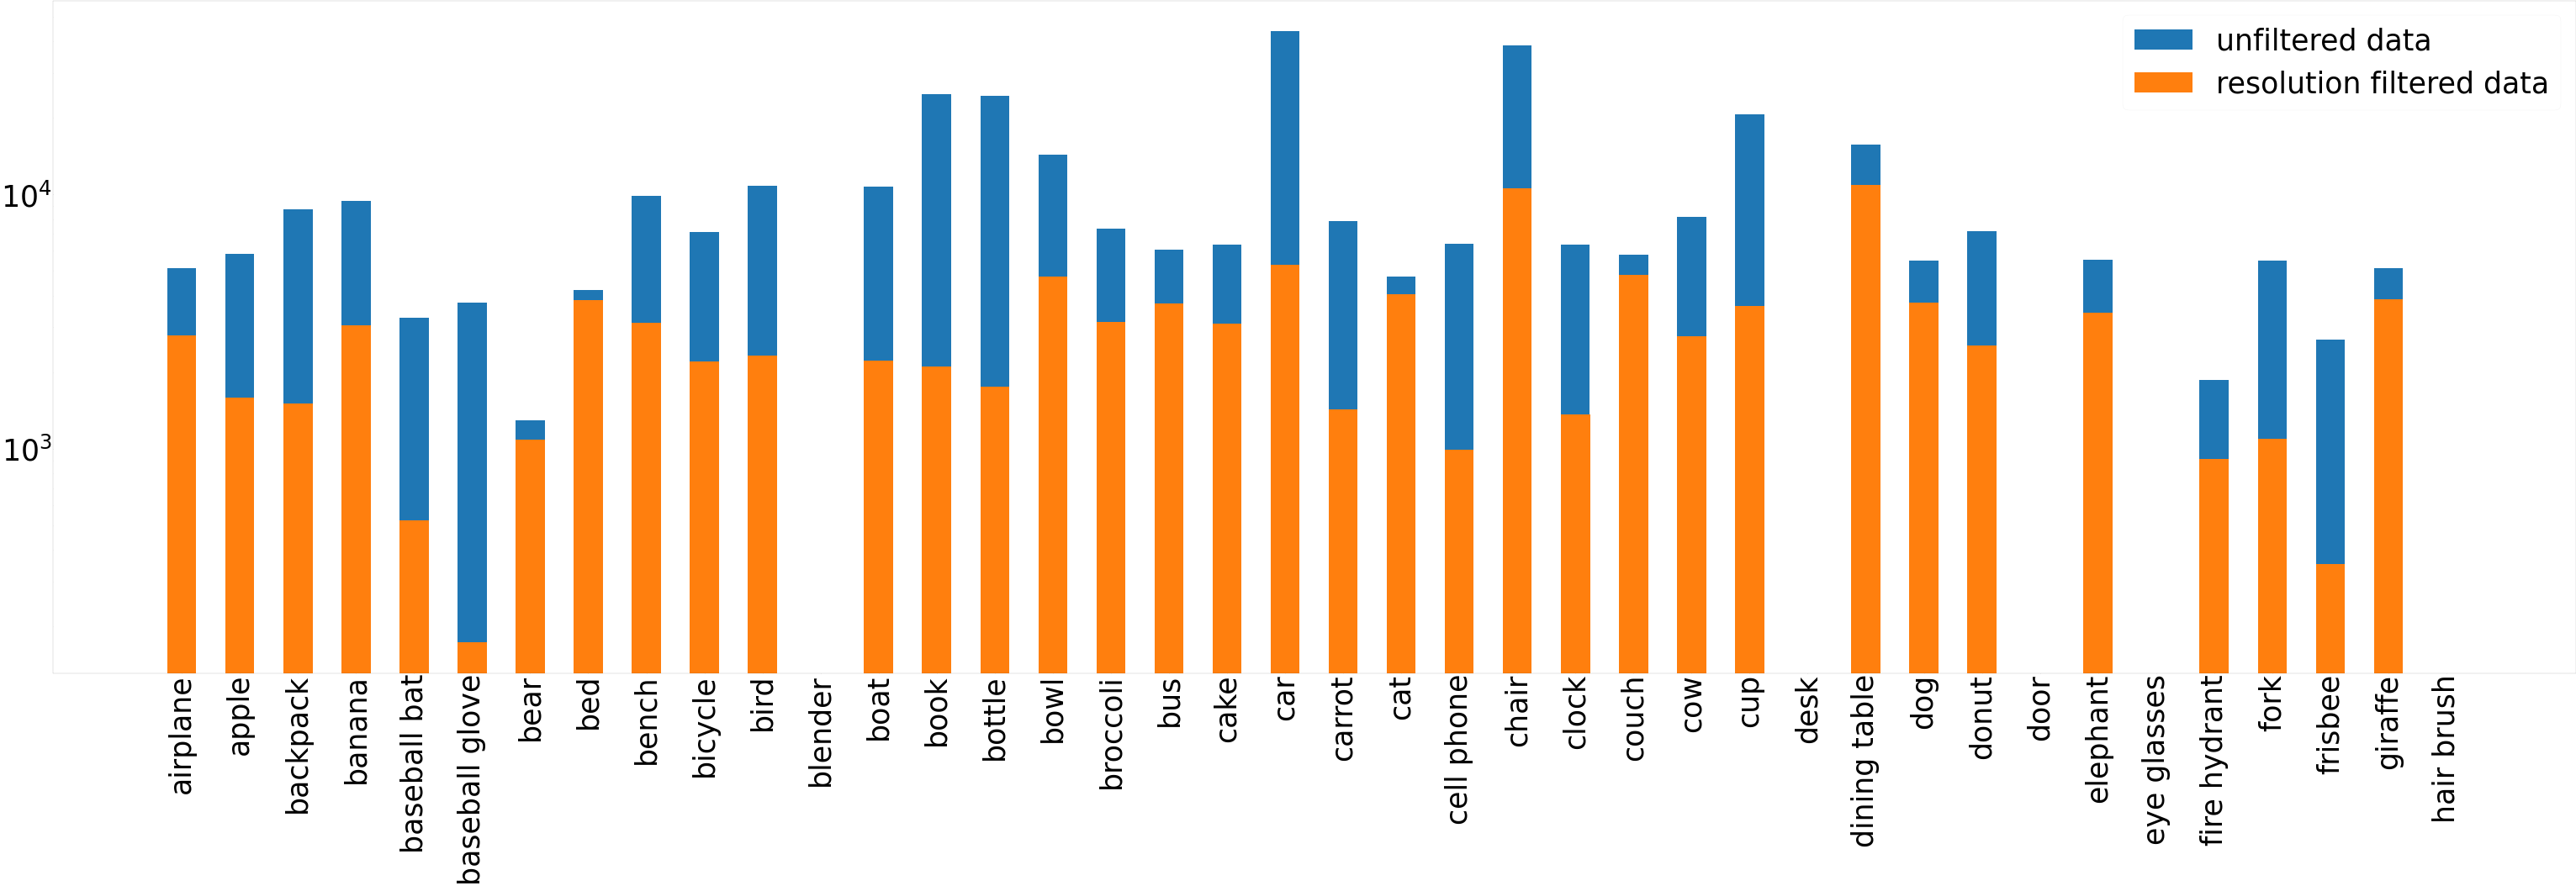

In [37]:
import matplotlib as plt
import numpy as np

classes = []
parsed_amounts = []
for c in os.listdir("data/train"):
    classes.append(c)
    parsed_amounts.append((c, len(os.listdir("data/train/{0}".format(c)))))

print(len(classes))
parsed_amounts = np.array(parsed_amounts)
plt.rcParams.update({'font.size': 250})
fig = plt.pyplot.figure(figsize=(300,80), dpi=10)
ax = fig.add_axes([0,0,1,1])

x_axis = np.arange(40)

tuplez = list(zip(amounts, parsed_amounts))

ax.bar(x_axis+0, width=0.5, height=np.asarray(amounts[:40,1],dtype=int), label="unfiltered data")
ax.bar(x_axis+0.0001, width=0.5, height=np.asarray(parsed_amounts[:40,1],dtype=int), label="resolution filtered data")

plt.pyplot.yscale("log")
plt.pyplot.xticks(rotation=90)
plt.pyplot.xticks(x_axis, classes[:40])
plt.pyplot.legend()

In [ ]:
def ts():
    return str(int(round(time.time() * 1000)))

if os.path.exists(TRANSFER_IMAGES):
    newclasses = os.listdir(TRANSFER_IMAGES)
    print(newclasses)

    os.mkdir(f"{TRANSFER_TRAIN_OUT}")
    os.mkdir(f"{TRANSFER_VAL_OUT}")
    for cn in newclasses:
        os.mkdir(f"{TRANSFER_TRAIN_OUT}/{cn}")
        os.mkdir(f"{TRANSFER_VAL_OUT}/{cn}")

    for i, val in enumerate(newclasses):
        files = os.listdir(f"{TRANSFER_IMAGES}/{val}")
        split = int(len(files)*0.8)

        for i2, val2 in enumerate(files):
            print(os.path.join(TRANSFER_IMAGES, val2))
            cvimg = cv2.imread(os.path.join(TRANSFER_IMAGES, val, val2))

            height, width, channel = cvimg.shape

            if height > width:
                cvimg = cv2.resize(cvimg, (int(224*(width/height)), 224))
            elif width > height:
                cvimg = cv2.resize(cvimg, (224, int(224*(height/width))))

            height, width, channel = cvimg.shape
            height_delta = max(224 - height, 0)
            width_delta = max(224 - width, 0)

            if height_delta > 0 or width_delta > 0:
                cvimg = cv2.copyMakeBorder(cvimg, int(height_delta/2), int(height_delta/2), int(width_delta/2), int(width_delta/2), cv2.BORDER_REPLICATE)
                
            cv2.imwrite(f"{TRANSFER_TRAIN_OUT if i2 < split else TRANSFER_VAL_OUT}/{val}/{ts()}.jpg", cvimg)    

In [13]:
#initial training labels
f = open('modules/coco_final_labels.py', "w")
f.write("labels = [\n")
for folder in os.listdir(TRAIN_OUTPUT_DIR):
    class_amount = len(os.listdir(f'{TRAIN_OUTPUT_DIR}/{folder}'))
    if class_amount > 0:
        f.write(f'"{folder}",\n')
f.write("]")  

#transfer training labels
f = open('modules/coco_final_labels_transfer.py', "w")
f.write("labels = [\n")
for folder in os.listdir(TRAIN_OUTPUT_DIR):
    class_amount = len(os.listdir(f'{TRAIN_OUTPUT_DIR}/{folder}'))
    if class_amount > 0:
        f.write(f'"{folder}",\n')
for folder in os.listdir(TRANSFER_IMAGES):
    class_amount = len(os.listdir(f'{TRANSFER_IMAGES}/{folder}'))
    if class_amount > 0:
        f.write(f'"{folder}",\n')
f.write("]") 

f.close()